<a href="https://colab.research.google.com/github/LxYuan0420/aws-machine-learning-university-accelerated-nlp/blob/master/colab_notebooks/MLA_NLP_Lecture3_Word_Vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning Accelerator - Natural Language Processing - Lecture 3**

**Word Vectors¶**

Word vectors refers to a family of related techniques, first gaining popularity via Word2Vec which associates an $n$-dimensional (normally $n$ is in the range of $50$ to $500$. For us it will be $300$) vector to every word in the target language.

We will first load a batch of word vectors known as ConceptNet Numberbatch, which have been found to have excellent performance while reducing issues of learning human bias. Learning how to construct these word vectors is a bit beyond the scope of what we can cover in this notebook, but this two-part blog post provides an excellent introduction.

We will go over these:

- How to get the most from this notebook
- Computing Distances
- Linear Structure of Word Vectors (Subtraction)
- Reverse Lookup
- Application: Analogies
- Visualization (PCA)

**1. How to get the most from this notebook**

(Go to top)

This builds out a solution in a step by step manner making it clear where data is being used and what tools are useful for exploration. After every code block, I encourage you to explore your own problem from beginning to end using these tools.

In [1]:
!wget https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-en-17.06.txt.gz

--2021-02-28 08:59:14--  https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-en-17.06.txt.gz
Resolving conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)... 52.216.246.36
Connecting to conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)|52.216.246.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 269500348 (257M) [text/plain]
Saving to: ‘numberbatch-en-17.06.txt.gz’

numberbatch-en-17.0 100%[===================>] 257.01M  39.8MB/s    in 6.4s    

2021-02-28 08:59:21 (40.3 MB/s) - ‘numberbatch-en-17.06.txt.gz’ saved [269500348/269500348]



In [2]:
!gzip -d numberbatch-en-17.06.txt.gz

In [3]:
!more numberbatch-en-17.06.txt | head -5

417194 300
## -0.0264 0.0468 -0.0099 -0.0242 -0.0762 0.0562 0.0863 0.0115 -0.0471 0.0442 -0.0875 0.0376 -0.0404 -0.0086 0.0161 -0.1689 0.1485 -0.0201 0.1021 -0.0635 -0.0317 0.0142 0.0588 -0.1299 -0.0905 0.0389 -0.0452 0.1352 0.0731 0.0648 0.1309 0.0493 0.0785 0.0154 -0.1015 0.1603 0.0429 -0.0860 0.0112 -0.0234 -0.0317 -0.0177 0.0262 -0.0854 -0.0502 0.0060 -0.0389 -0.0306 0.1039 -0.0059 0.0581 0.0387 -0.0071 -0.0459 0.0889 -0.0225 -0.1519 0.0183 -0.0499 0.0031 -0.0135 0.0781 0.0779 0.0764 -0.0349 0.0237 -0.0913 -0.0135 0.0197 -0.0859 0.0977 0.0555 -0.1392 0.0621 0.0043 -0.0910 -0.0492 0.1207 0.0680 -0.0766 0.1148 -0.0516 0.0889 0.0005 0.0418 -0.0148 -0.1174 -0.0028 -0.0364 0.2235 0.0457 0.0742 -0.0247 0.0750 -0.0161 -0.0358 0.0904 0.0243 0.0878 -0.0349 -0.0338 0.0341 0.0033 -0.1524 0.0120 0.0512 -0.1012 0.1893 0.0160 0.0901 -0.0088 -0.0117 -0.0402 0.0127 0.0599 0.0554 -0.0355 0.0166 0.0081 0.0735 -0.0492 -0.0143 0.0236 0.0316 0.0123 -0.0962 -0.0296 0.0214 0.0457 -0.0269 0.0250 -0.0744 0

In [4]:
import pandas as pd
import numpy as np

words = pd.read_csv("numberbatch-en-17.06.txt", sep=" ", index_col=0, header=None, skiprows=[0]).transpose()

In [6]:
words.head()

,##,###,####,#####,#####_metres,#####ish,####_adapter,####_form,####_ish,####_metres,####_ndash_####,####_number,####_pennsylvania_avenue,####_spelling_reform,####_yen,####ed,####s,####th,"###,###",###.##e,###.##i,###_ammonia,###_backflip,###_cell,###_days,###_days_long,###_degree,###_fraud,###_hamburger,###_k,###_k_plan,###_meters,###_metres,###_number,###_percent,###_pound_gorilla,###_proof,###_reset,###_scam,###_scams,...,ᵣ,ḍamma,ḷḷena,№,ℝ,ℝ_order_tree,℞,℟,™,ℤ,ⅵ,─,●,☃,♀,♥,♫,✓,⠈_⠎,⠈_⠒_⠏,⠈_⠲,⠉_⠧,⠉_⠧_⠛,⠐_⠂,⠐_⠤,⠗_⠚_⠉,⠙_⠉_⠇,⠠_⠶,⠤_⠤,⠤_⠤_⠤,⠧_⠎,⠨_⠴,⠭_⠋,⠭_⠎,⠽_⠗,⠽_⠗_⠋,形容動詞,形容詞,李,인
1,-0.0264,-0.0096,-0.0364,-0.0322,-0.0633,0.0408,-0.0311,0.0263,-0.0222,0.0120,-0.1604,-0.0357,-0.1335,-0.1406,-0.1005,0.1555,0.0193,0.0397,-0.0293,-0.0870,-0.0555,-0.0127,0.1309,-0.0575,0.0088,-0.0011,0.0858,0.0295,-0.0434,-0.0302,-0.0450,-0.0176,0.0120,-0.0400,0.1241,0.1648,0.1261,0.0747,-0.1146,-0.1673,...,0.0137,-0.0903,-0.1942,-0.0131,-0.0363,0.0391,0.0730,0.0322,0.0742,0.0061,0.0180,0.0409,0.0458,-0.0053,-0.0710,0.0553,0.0205,0.0733,-0.0922,-0.0922,-0.0922,-0.0747,-0.0747,-0.1759,-0.1433,0.0109,0.0553,-0.1670,-0.1832,-0.2139,-0.0260,-0.0922,0.0371,0.0241,0.0591,0.0584,-0.0532,-0.0532,-0.0825,-0.1633
2,0.0468,0.0318,0.0254,-0.0619,-0.0772,-0.0174,-0.0403,-0.0786,-0.0266,0.0121,0.0177,-0.0027,0.0621,-0.2005,-0.1610,0.0809,0.0372,0.0062,-0.0255,-0.1933,-0.1970,-0.3649,0.0536,-0.2338,0.0312,0.0261,0.0183,0.0000,-0.0355,-0.1048,-0.1020,-0.0153,0.0142,-0.0707,0.1127,0.0941,0.0466,-0.0751,-0.1572,-0.2181,...,-0.2405,-0.0638,-0.1614,0.0326,-0.1910,-0.0971,-0.1453,-0.0240,-0.0099,-0.1891,0.0050,0.0322,0.0534,-0.0375,-0.0996,0.0682,0.0095,-0.0442,-0.1200,-0.1200,-0.1200,-0.1220,-0.1220,-0.3621,-0.1710,-0.0026,0.0378,-0.3415,-0.2051,-0.2424,-0.0354,-0.1200,-0.0075,-0.0100,0.0319,0.0273,-0.1060,-0.1060,-0.0578,-0.2578
3,-0.0099,-0.0095,-0.0448,-0.0742,-0.1488,-0.1162,-0.1117,-0.1316,-0.1564,-0.0202,-0.0872,-0.0534,-0.1341,-0.1874,-0.2119,-0.0420,0.0516,-0.0275,-0.0528,-0.2244,-0.1862,0.2391,0.0038,-0.0548,-0.0636,-0.0765,-0.0287,-0.1927,-0.0615,-0.2233,-0.2690,-0.0538,-0.0061,-0.1031,0.0981,-0.1152,0.0421,-0.1842,-0.3110,-0.3479,...,-0.0533,-0.0887,-0.2111,-0.0641,-0.2297,-0.1053,-0.0442,-0.1338,0.0625,-0.1604,-0.0294,0.0132,0.0561,0.0025,-0.0454,-0.0103,0.0428,-0.0153,-0.2133,-0.2133,-0.2133,-0.1958,-0.1958,-0.5084,-0.3167,-0.1411,-0.1831,-0.5053,-0.3969,-0.4504,-0.2038,-0.2133,-0.0978,-0.1075,-0.1338,-0.1340,-0.1399,-0.1399,-0.0945,-0.1895
4,-0.0242,-0.0420,-0.0327,0.0355,0.0472,-0.0440,-0.0828,-0.0781,-0.0659,-0.0377,-0.0341,0.0382,-0.0041,0.0411,0.2656,-0.1084,-0.0379,-0.1053,0.0231,0.0020,-0.0783,-0.1509,0.0450,-0.2405,0.0212,0.0379,-0.0597,0.0237,0.0002,0.0362,0.0561,0.0134,-0.0150,0.0541,-0.0593,-0.0323,-0.0354,-0.0335,0.1331,0.1846,...,-0.2991,0.0323,0.2292,-0.0850,-0.2362,-0.2447,-0.0655,-0.1095,-0.0171,-0.2683,-0.0192,-0.0387,-0.0210,0.1499,0.0164,0.0985,0.0687,0.0313,0.1314,0.1314,0.1314,0.1164,0.1164,0.2368,0.1758,0.1390,0.0265,0.2297,0.2100,0.2037,0.0725,0.1314,0.0017,0.0048,0.1210,0.1161,-0.1423,-0.1423,0.0680,0.1788
5,-0.0762,-0.0831,-0.0712,0.0211,-0.1084,-0.0777,-0.0941,-0.0050,-0.0228,-0.1128,-0.0022,-0.1202,-0.1301,0.1228,-0.0292,0.0929,-0.0053,-0.0131,-0.0238,-0.0985,-0.1206,-0.0409,-0.1064,0.0001,-0.0220,-0.0694,-0.0729,-0.1445,-0.0316,-0.0008,-0.0239,-0.1087,-0.1237,-0.0791,0.0621,0.0439,0.0780,-0.1404,-0.0979,-0.0610,...,0.0588,0.0420,0.0017,-0.0371,0.0076,-0.1300,0.0874,0.1237,-0.0535,-0.0396,-0.0935,0.0508,-0.0347,-0.0482,0.0763,0.1112,0.0651,-0.0565,0.0146,0.0146,0.0146,0.0172,0.0172,0.0389,0.0029,0.1063,0.0394,0.0287,-0.0088,-0.0279,0.0395,0.0146,0.0362,0.0118,0.0143,0.0259,0.1371,0.1371,-0.0124,0.0823


In [7]:
print(words["house"])

1      0.0331
2      0.1253
3      0.0865
4      0.0641
5     -0.1315
        ...  
296   -0.0046
297   -0.0053
298    0.0449
299   -0.0277
300   -0.0500
Name: house, Length: 300, dtype: float64



**2. Computing Distances**

(Go to top)

As part of our "manipulation primitives", we often need to be able to compute distances between vectors associated to words. So we start by writing a little snippet that lets us do so. numpy makes this fairly easy to do. Remember that small distances correspond to similar words, so lets check this by going through and writing a little code that takes three words and tells you if the first word is closer to the second than the third.

In [14]:
def dist(w1, w2):
    return np.linalg.norm(words[w1] - words[w2])

def distCompare(w1, w2, w3):
    d2 = dist(w1, w2)
    d3 = dist(w1, w3)
    if d2 < d3:
        print(f"{w1} is closers to {w2} than {w3}")
    else:
        print(f"{w1} is closers to {w3} than {w2}")

In [15]:
distCompare("orb", "ball", "hockey")
distCompare("picked", "lifted", "play")
distCompare("pink", "red", "blue")

orb is closers to ball than hockey
picked is closers to lifted than play
pink is closers to red than blue


We see that it mostly agrees with what we anticipated. If you continued to ask more questions, you'd find some things that disagree with what you would expect (for instance, it believes that 'maroon' is closer to 'blue' than 'red'), but on the whole, you'll find it agrees with the intuition that similar words should be close to one another.

**3. Linear Structure of Word Vectors (Subtraction)**

(Go to top)

If word vectors only put similar words next to one another, they would have never garnered the interest that they have obtained from the community. Indeed they actually contain subtle and nuanced understanding of the meanings of words. It will take a while to explore what this means, but the mantra that we should now internalize is "relationships = directions" which is to say that words that share a similar relationship, will be separated from one another in the same direction.

As we saw, vector subtraction lets us examine this. However, since vector subtraction is as simple as

diff = v - w
there is not much to look at here.

**4. Reverse Lookup**

(Go to top)

Reverse lookup will allow us to probe the finer structure of word vectors. In particular, we will now create a reverse lookup routine that finds the $k$ closest words to a given vector. As the straight-forward implementation will be too slow (looping over every element of words) we will provide you with a numpy implementation which will be fast enough for our needs.

In [23]:
# drop things containing underscores (there are compound terms like "young_man" that our code will not use)
# and convert to matrix format for faster computation

labels  = words.columns.values.tolist()
labels = np.array([w for w in labels if isinstance(w,str) and w.isalpha()])
#wordsMatrix = words[labels].as_matrix()
wordsMatrix = words[labels].values


# snipped to find the closest word (or vector)
def find_closest_word(v, k = 1):
    if type(v) == type('str'):
        v = words[v]
    diff = wordsMatrix - v.values.reshape(-1,1)
    delta = np.linalg.norm(diff, axis=0)
    return labels[np.argsort(delta)[:k]]
    
print(find_closest_word('blue', 50))

['blue' 'bluecurls' 'bluishness' 'bluer' 'unblue' 'bluest' 'blueish'
 'cyanol' 'bluely' 'gridelin' 'iridovirus' 'ceruleous' 'roygbiv'
 'cyanophore' 'lazuline' 'berylline' 'acyanopia' 'bluing' 'blueness'
 'chromostereopsis' 'umangite' 'red' 'yellowred' 'bluet' 'bluetit'
 'purple' 'yellow' 'kumst' 'cerulean' 'purpre' 'mauvette' 'bepurple'
 'bluish' 'purpureal' 'pyrrh' 'deredden' 'indigoidine' 'zaffre' 'argb'
 'bloncket' 'turquoisey' 'puniceous' 'luteo' 'rubiform' 'xanthous'
 'xanthochromic' 'crustaceorubin' 'tetronerythrin' 'vitellorubin'
 'cyanophyll']


Seems to work to me! Lots of blue related words, and then words related to other colors. Many of them, like 'tetronerythrin' actually relate to specific pigments.

**5. Application: Analogies**

(Go to top)

Let us suppose that we have four associated word vectors $v_{man}$, $v_{woman}$, $v_{boy}$, and $v_{girl}$. If we believe the idea that "relationship = direction" then, this becomes a vector relationship, where the vector that takes us from $v_{man}$ to $v_{woman}$ should be the same as the vector that takes us from $v_{boy}$ to $v_{girl}$. Recalling that vector subtraction is what gives us such a direction, this becomes$$
v_{woman} - v_{man} \approx v_{girl} - v_{boy}
$$

Suppose you now wanted to solve an analogy using this idea. Say we were just given man:woman::boy:? and we wanted to find the question mark. The expression above can be rearranged by adding $v_{boy}$ to both sides to yield$$
v_{?} \approx v_{woman} - v_{man} + v_{boy}
$$Thus the word we are looking for should hopefully be the word whose associated vector is closest to $v_{woman} - v_{man} + v_{boy}$. Let's see how this works out in code.

In [26]:
def analogy(w1, w2, w3, k=1):
    listPoss = find_closest_word(words[w1]-words[w2]+words[w3], k)
    print(f"{w1}: {w2} :: {w3} : {listPoss}")

In [27]:
analogy("man", "woman", "boy", 2)
analogy("short", "tall", "shortest", 2)
analogy("seattle", "washington", "minneapolis", 2)

man: woman :: boy : ['boy' 'boyism']
short: tall :: shortest : ['shortest' 'short']
seattle: washington :: minneapolis : ['minneapolitan' 'minneapolis']


All in all, this should have worked fantastically! The first one will indeed show that man : woman :: boy : girl as the most likely choice. The second will state that short : tall :: shortest : tallest is the most likely case indicating that it understands how to turn words into superlatives (not just a simple relationship of size). The third one indicates it understands what the largest cities in Washington and Minnesota are and can retrieve that information if needed.

**6. Visualization (PCA)**

(Go to top)

Let's implement our last little primitive: the ability to automatically visualize what a collection of vectors is doing by projecting it onto the best possible pair of directions. We will use sklearn to do this.

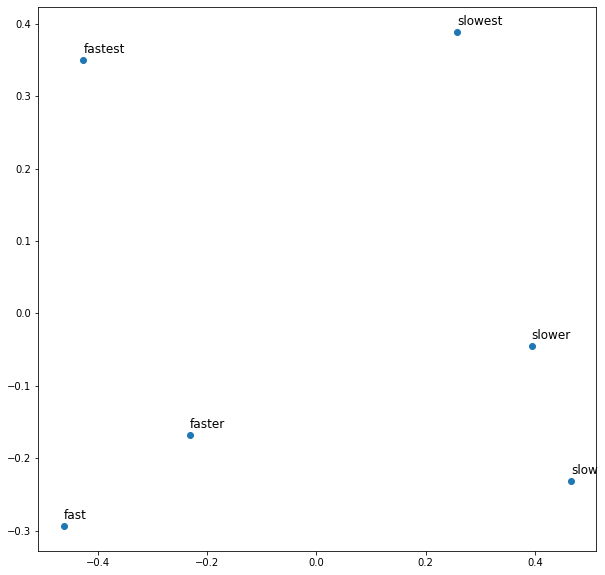

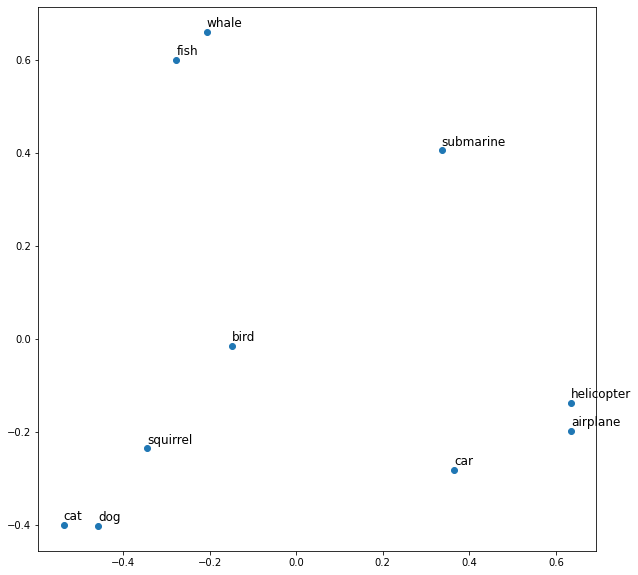

In [28]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def pcaPlot(word_list):
    vecs = [words[w] for w in word_list]

    #reduce dimensions
    model = PCA(n_components=2)
    reduced = model.fit_transform(vecs)
    xc = [v[0] for v in reduced]
    yc = [v[1] for v in reduced]

    # plot them
    plt.figure(figsize=(10,10))
    plt.scatter(xc, yc)

    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(xc[i], yc[i]+0.01), fontsize=12)
    plt.show()

pcaPlot(['fast','faster','fastest','slow','slower','slowest'])
pcaPlot(['bird', 'cat', 'squirrel', 'dog', 'fish', 'helicopter', 'airplane', 'car', 'submarine', 'whale'])

In [29]:
!rm numberbatch-en-17.06.txt